In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
from astropy.table import Table, Column
from tqdm.notebook import tqdm
from scikitplot.metrics import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
sed_lib = Table.read('/home/aalvarez/Work/Data/SC7/TU/Stars/Deep/EUC-TEST-SEDLIB-2013-11-14_MODIF.fits')

In [3]:
deep = Table.read('/home/aalvarez/Phosphoros/Results/SC7_Stars/Deep/phz_cat.fits')

In [4]:
true_seds = sed_lib[deep['SED_TEMPLATE']]

In [5]:
spectral_names = np.array(['O', 'B', 'A', 'F', 'G', 'K', 'M'])
lumi_names = np.flip(np.array(['i', 'ii', 'iii', 'iv', 'v']))

In [6]:
temp_to_spectral = Table([
    Column(['O', 'B', 'A', 'F', 'G', 'K', 'M'], name='T'),
    Column([30000, 10000, 7500, 6000, 5200, 3700, 0.], name='MIN'),
    Column([np.inf, 30000, 10000, 7500, 6000, 5200, 3700], name='MAX')
])

In [7]:
temp_to_spectral

T,MIN,MAX
str1,float64,float64
O,30000.0,inf
B,10000.0,30000.0
A,7500.0,10000.0
F,6000.0,7500.0
G,5200.0,6000.0
K,3700.0,5200.0
M,0.0,3700.0


In [8]:
sed_re = re.compile('uk([rw]?)(\w\d+(\.\d+)?)(\w+)')
classification = {
    'true_spectral_type': [],
    'spectral_type': [],
    'luminosity_type': [],
}
for true, fitted in tqdm(zip(true_seds, deep['SED']), total=len(true_seds)):
    # Fitted sed
    sed_name = fitted.split('/')[2]
    match = sed_re.match(sed_name)
    if not match:
        raise Exception(sed_name)
    classification['spectral_type'].append(match.group(2)[0].upper())
    classification['luminosity_type'].append(match.group(4))
    # True SED
    match = np.logical_and(temp_to_spectral['MIN'] < true['TEFF'], true['TEFF'] <= temp_to_spectral['MAX'])
    assert match.any()
    classification['true_spectral_type'].append(temp_to_spectral['T'][match][0])

In [9]:
for k in classification:
    classification[k] = np.array(classification[k])

In [10]:
spectral_sorter = np.argsort(spectral_names)
true_spectral = spectral_sorter[np.searchsorted(spectral_names, classification['true_spectral_type'], sorter=spectral_sorter)]
spectral = spectral_sorter[np.searchsorted(spectral_names, classification['spectral_type'], sorter=spectral_sorter)]

In [11]:
spectral_names

array(['O', 'B', 'A', 'F', 'G', 'K', 'M'], dtype='<U1')

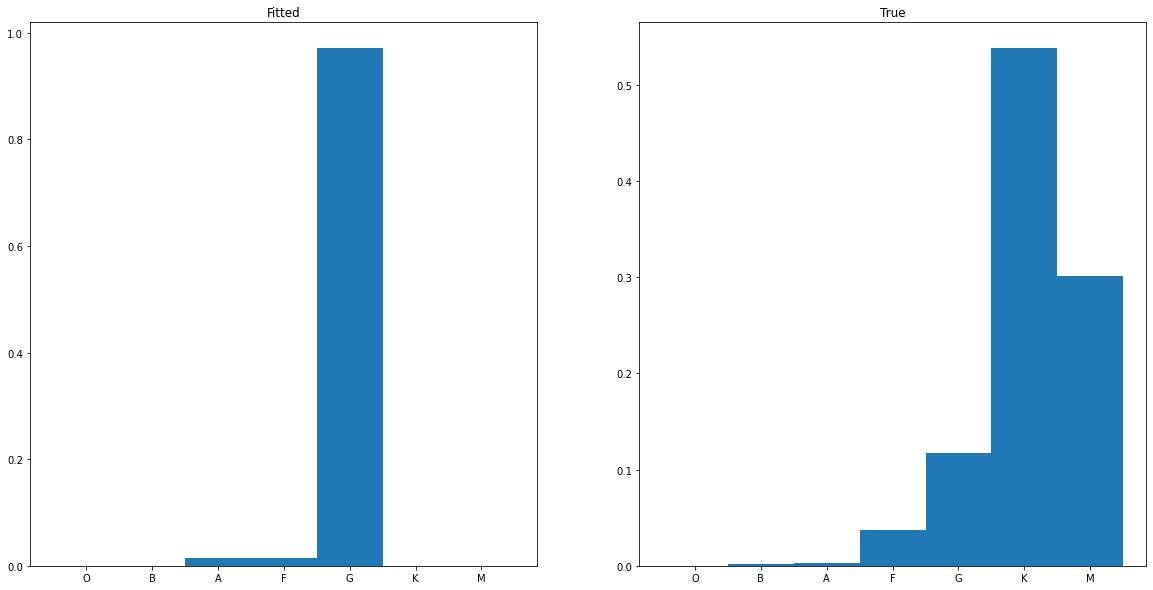

In [12]:
fig, axes = plt.subplots(ncols=2)

axes[0].hist(spectral, bins=np.arange(-0.5, len(spectral_names)), density=True)
axes[0].set_xticks(np.arange(0, len(spectral_names)))
axes[0].set_xticklabels(spectral_names)
axes[0].set_title('Fitted')

axes[1].hist(true_spectral, bins=np.arange(-0.5, len(spectral_names)), density=True)
axes[1].set_xticks(np.arange(0, len(spectral_names)))
axes[1].set_xticklabels(spectral_names)
axes[1].set_title('True')

plt.show()

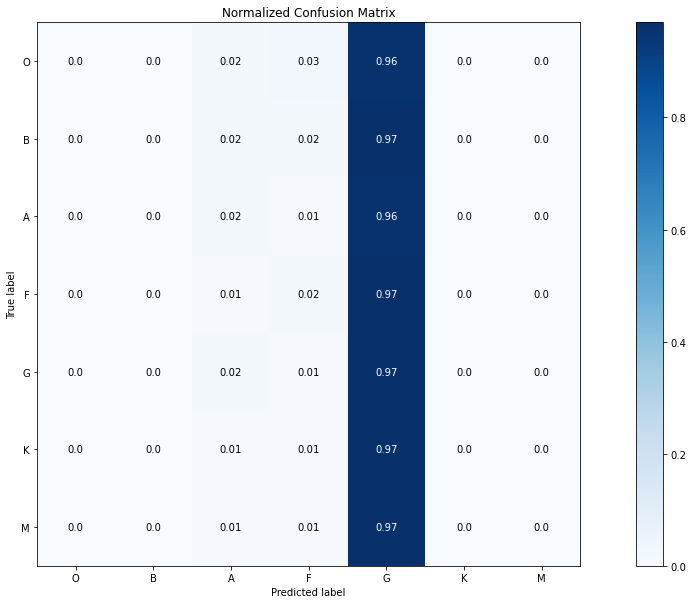

In [13]:
plot_confusion_matrix(spectral_names[true_spectral], spectral_names[spectral], labels=spectral_names, normalize=True)